## Synopsis

The goal of this project is to analayze which factors contribute to employee attrition and to develop a model that predicts whether an employee is a possible candidate for a 'break down'.

The data set can be downloaded from kaggle: https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

## Load Data Set

In [2]:
data_file = 'WA_Fn-UseC_-HR-Employee-Attrition.csv'
df = pd.read_csv(data_file)
df.columns = df.columns.str.lower()

## Data Preparation

1. Remove the employee number from the model since unique for each employee and is not relevant for the ML model.

In [3]:
del df['employeenumber']

2. *Zero Variance*: Check for features that have only 1 unique value.

In [4]:
df.nunique().nsmallest(10)

employeecount        1
over18               1
standardhours        1
attrition            2
gender               2
overtime             2
performancerating    2
businesstravel       3
department           3
maritalstatus        3
dtype: int64

Remove employee count/over 18/ standard hours features since all rows have the same value. Those features are therefore not relevant for the ML model.

In [5]:
del df['employeecount']
del df['over18']
del df['standardhours']

3. *Null Value Check*: Check for missing values.

In [6]:
df.isnull().sum()

age                         0
attrition                   0
businesstravel              0
dailyrate                   0
department                  0
distancefromhome            0
education                   0
educationfield              0
environmentsatisfaction     0
gender                      0
hourlyrate                  0
jobinvolvement              0
joblevel                    0
jobrole                     0
jobsatisfaction             0
maritalstatus               0
monthlyincome               0
monthlyrate                 0
numcompaniesworked          0
overtime                    0
percentsalaryhike           0
performancerating           0
relationshipsatisfaction    0
stockoptionlevel            0
totalworkingyears           0
trainingtimeslastyear       0
worklifebalance             0
yearsatcompany              0
yearsincurrentrole          0
yearssincelastpromotion     0
yearswithcurrmanager        0
dtype: int64

**We don’t have to handle missing values** in the dataset: all the values in all the columns are present.

4. Map numerical values to labels for categorical features.

In [7]:
education_values = {
    0: 'unk',
    1: 'Below College',
    2: 'College',
    3: 'Bachelor',
    4: 'Master',
    5: 'Doctor'
}
df.education = df.education.map(education_values)


environmentsatisfaction_values = {
    0: 'unk',
    1: 'low',
    2: 'medium',
    3: 'high',
    4: 'very high'
}
df.environmentsatisfaction = df.environmentsatisfaction.map(environmentsatisfaction_values)


jobinvolvement_values = {
    0: 'unk',
    1: 'low',
    2: 'medium',
    3: 'high',
    4: 'very high'
}
df.jobinvolvement = df.jobinvolvement.map(jobinvolvement_values)


jobsatisfaction_values = {
    0: 'unk',
    1: 'low',
    2: 'medium',
    3: 'high',
    4: 'very high'
}
df.jobsatisfaction = df.jobsatisfaction.map(jobsatisfaction_values)


performancerating_values = {
    0: 'unk',
    1: 'low',
    2: 'good',
    3: 'excellent',
    4: 'outstanding'
}
df.performancerating = df.performancerating.map(performancerating_values)


relationshipsatisfaction_values = {
    0: 'unk',
    1: 'low',
    2: 'medium',
    3: 'high',
    4: 'very high'
}
df.relationshipsatisfaction = df.relationshipsatisfaction.map(relationshipsatisfaction_values)

worklifebalance_values = {
    0: 'unk',
    1: 'bad',
    2: 'good',
    3: 'better',
    4: 'best'
}
df.worklifebalance = df.worklifebalance.map(worklifebalance_values)

5. Convert boolean values to 1 and 0:

In [8]:
df['attrition'] = (df.attrition == 'Yes').astype(int)
df['overtime'] = (df.overtime == 'Yes').astype(int)

6. Create training, validation and test data sets:

In [9]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1234)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1234)

y_full_train = df_full_train['attrition']
y_train = df_train['attrition']
y_val = df_val['attrition']
y_test = df_test['attrition']

In [10]:
df_full_train.head().T

,630,1221,122,706,87
age,22,45,56,40,51
attrition,0,0,1,1,0
businesstravel,Travel_Rarely,Non-Travel,Travel_Rarely,Non-Travel,Travel_Rarely
dailyrate,1230,1238,441,1479,432
department,Research & Development,Research & Development,Research & Development,Sales,Research & Development
distancefromhome,1,1,14,24,9
education,College,Below College,Master,Bachelor,Master
educationfield,Life Sciences,Life Sciences,Life Sciences,Life Sciences,Life Sciences
environmentsatisfaction,very high,high,medium,medium,very high
gender,Male,Male,Female,Female,Male


## Explorative Data Analysis

### Feature Analysis

1. Check the distribution of the target variable (majority vs. minority class)

In [11]:
y_train.value_counts()

0    734
1    148
Name: attrition, dtype: int64

So in the majority class we find **734** entries and **148** entries in the minority class. This results in the following attrition score:

In [12]:
round(y_train.mean(), 2)

0.17

**17% of all employees** suffered from attrition, which makes the data set imbalanced. We will need to take that into account when tuning and evaluating the results of the ML models!

2. Retrieve the numerical and categorical values

In [13]:
numeric_feats = []
categorical_feats = []
for col in df_full_train.columns:
    if col != 'attrition':
        if col == 'overtime':
            categorical_feats.append(col) # boolean feature
        elif (df_full_train[col].dtype == np.float64 or df_full_train[col].dtype == np.int64):
            numeric_feats.append(col)
        else:
            categorical_feats.append(col)
            
numeric_feats, categorical_feats

(['age',
  'dailyrate',
  'distancefromhome',
  'hourlyrate',
  'joblevel',
  'monthlyincome',
  'monthlyrate',
  'numcompaniesworked',
  'percentsalaryhike',
  'stockoptionlevel',
  'totalworkingyears',
  'trainingtimeslastyear',
  'yearsatcompany',
  'yearsincurrentrole',
  'yearssincelastpromotion',
  'yearswithcurrmanager'],
 ['businesstravel',
  'department',
  'education',
  'educationfield',
  'environmentsatisfaction',
  'gender',
  'jobinvolvement',
  'jobrole',
  'jobsatisfaction',
  'maritalstatus',
  'overtime',
  'performancerating',
  'relationshipsatisfaction',
  'worklifebalance'])

3. Check the number of distinct values for the categorical features

In [14]:
df_full_train[categorical_feats].nunique()

businesstravel              3
department                  3
education                   5
educationfield              6
environmentsatisfaction     4
gender                      2
jobinvolvement              4
jobrole                     9
jobsatisfaction             4
maritalstatus               3
overtime                    2
performancerating           2
relationshipsatisfaction    4
worklifebalance             4
dtype: int64

All the categorical features have very few distinct values!

### Feature Importance Analysis

#### Mutual Information Score
For the categorical features we analyze the mutual info score:

In [15]:
from sklearn.metrics import mutual_info_score

In [16]:
df_mi = df_full_train[categorical_feats].apply(lambda series : mutual_info_score(series, df_full_train.attrition))
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')
df_mi

,MI
jobrole,0.026500
overtime,0.024177
maritalstatus,0.017052
environmentsatisfaction,0.009965
jobinvolvement,0.009961
jobsatisfaction,0.007847
businesstravel,0.006381
educationfield,0.004897
worklifebalance,0.003935
department,0.003115


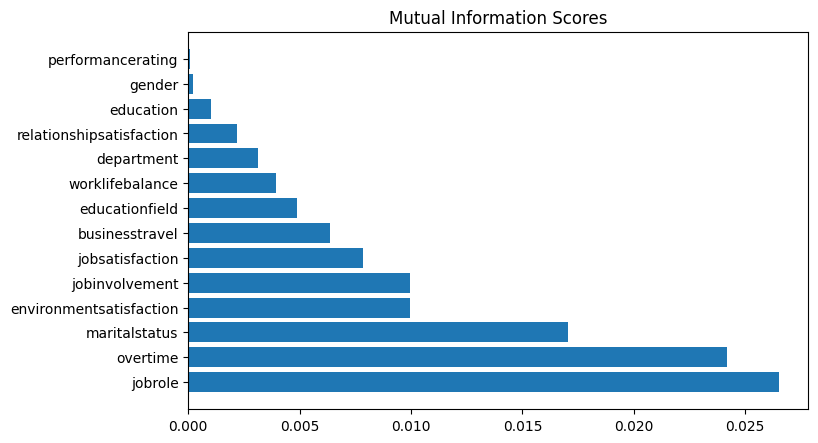

In [17]:
def plot_mi_scores(scores):
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores.MI)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(df_mi)

It seems that **job role**, **overtime** and **marital status** are the most important features.

#### Correlation Coefficient
For the numerical features we analyze the correlation coefficient.

In [18]:
df_cc = df_full_train[numeric_feats].corrwith(df_full_train.attrition)
df_cc = df_cc.sort_values(ascending=False).to_frame(name='CC')
df_cc

,CC
distancefromhome,0.094485
numcompaniesworked,0.048646
monthlyrate,0.007300
yearssincelastpromotion,-0.009060
hourlyrate,-0.015512
percentsalaryhike,-0.026373
dailyrate,-0.042882
trainingtimeslastyear,-0.047180
yearsatcompany,-0.113653
yearsincurrentrole,-0.140518


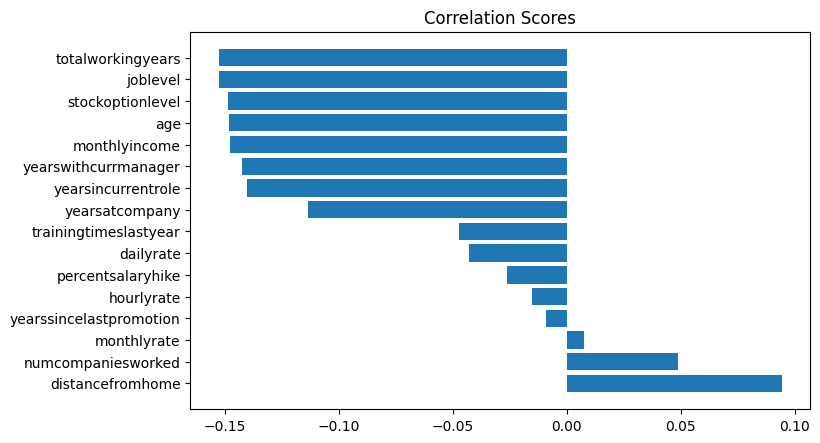

In [19]:
def plot_correlation_scores(scores):
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores.CC)
    plt.yticks(width, ticks)
    plt.title("Correlation Scores")

plt.figure(dpi=100, figsize=(8, 5))
plot_correlation_scores(df_cc)

**distance from home** and the **number of campanis worked** seem to be factors of attrition more than any other features. Features that reduce the attrition risk are the **total working years**, the **job level** and the **stock option level**.

## Feature Engineering

1. We delete the target variable from the data sets.

In [20]:
del df_full_train['attrition']
del df_train['attrition']
del df_val['attrition']
del df_test['attrition']

2. We need to encode our categorical features as numeric features.

In [21]:
from sklearn.feature_extraction import DictVectorizer

In [22]:
dv = DictVectorizer(sparse=False)

full_train_dict = df_full_train[categorical_feats + numeric_feats].to_dict(orient='records')
dv.fit(full_train_dict)
X_full_train = dv.transform(full_train_dict)

train_dict = df_train[categorical_feats + numeric_feats].to_dict(orient='records')
X_train = dv.transform(train_dict)

val_dict = df_val[categorical_feats + numeric_feats].to_dict(orient='records')
X_val = dv.transform(val_dict)

test_dict = df_test[categorical_feats + numeric_feats].to_dict(orient='records')
X_test = dv.transform(test_dict)

## Machine Learning Models

We will try the following ML models:

1. Logistic Regression
2. Weighted Logistic Regression
3. Decision Trees
4. Random Forest
5. Gradient Boosting

and then select/save/use the model with the best results on the test data set.

### Logistic Regression
First we will try a simple logistic regression.

#### Fitting the Model

In [23]:
from sklearn.linear_model import LogisticRegression

In [24]:
model_lg = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=1234)
model_lg.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=1234)

#### Evaluating the Model


In [25]:
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, confusion_matrix

In [26]:
def validate_results(y_val, y_pred):
    print(f'Accuracy Score: {round(accuracy_score(y_val, y_pred), 3)}')
    print(f'Area Under ROC Curve: {round(roc_auc_score(y_val, y_pred), 3)}')
    print(f'Recall score: {round(recall_score(y_val, y_pred), 3)}')
    print(f'Confusion Matrix: \n{confusion_matrix(y_val, y_pred)}')

In [27]:
y_pred_lg = model_lg.predict(X_val)
validate_results(y_val, y_pred_lg)

Accuracy Score: 0.884
Area Under ROC Curve: 0.665
Recall score: 0.357
Confusion Matrix: 
[[245   7]
 [ 27  15]]


Although the accuracy score is quite good, the model is not doing a good job in predicting the minority class:
**only 15 of 42** cases were **predicted correctly** (AU ROC **0.665**, recall **0.357**)!

### Weighted Logistic Regression
To handle the inbalance in the data set, we define weights that represents the distribution of the target variable. Recall that only 17% (148/734) of the data set records have the attrition variable set to 1. We specify therefore the weights as the inverse of the target variable distribution. For majority class (no attrition), will use weight of 148 and for minority class (attrition), will use weight of 734. So the penalty of wrong prediction of minority class would be ca. 5 times more severe than wrong prediction of majority class.

In [28]:
first_weight = {0: y_train.value_counts()[1], 1: y_train.value_counts()[0]}
model_lg = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=1234, class_weight=first_weight)
model_lg.fit(X_train, y_train)

LogisticRegression(class_weight={0: 148, 1: 734}, max_iter=10000,
                   random_state=1234)

In [29]:
y_pred_lg = model_lg.predict(X_val)
validate_results(y_val, y_pred_lg)

Accuracy Score: 0.748
Area Under ROC Curve: 0.734
Recall score: 0.714
Confusion Matrix: 
[[190  62]
 [ 12  30]]


This new model is performing better, the **recall score** has improved from **0.357** to **0.714** and the **AUC ROC** from **0.665** to **0.734** and it is therefore much better in predicting the minority class.

#### Tuning the model
##### Class Weight
Now we check whether another weight might lead to a further improvement.

In [30]:
from sklearn.model_selection import GridSearchCV, PredefinedSplit
import random
random.seed(1234)

# we generate an index from Cross Validation with 10 possible folds
split_index = [-1 if x in df_train.index else random.randint(0, 9) for x in df_full_train.index]
pds = PredefinedSplit(test_fold = split_index)

In [31]:
def create_grid_search_cv(model, hyperparam, scoring="roc_auc"):
    grid = GridSearchCV(model, hyperparam, scoring=scoring, cv=pds, n_jobs=-1, refit=True)
    grid.fit(X_full_train, y_full_train)
    print(f'Best score: {round(grid.best_score_, 3)} with param: {grid.best_params_}')
    return(grid)

In [32]:
w_range = [first_weight, {0:1, 1:4}, {0:1, 1:4.5}, {0:1, 1:5}, {0:1, 1:5.5}, {0:1, 1:6}]
hyperparam_lg = {"class_weight": w_range}

model_lg = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=1234)
grid_lg = create_grid_search_cv(model_lg, hyperparam_lg)

best_weight = grid_lg.best_params_['class_weight']
best_weight

Best score: 0.821 with param: {'class_weight': {0: 1, 1: 4}}


{0: 1, 1: 4}

In [33]:
y_pred_lg = grid_lg.predict(X_val)
validate_results(y_val, y_pred_lg)

Accuracy Score: 0.827
Area Under ROC Curve: 0.78
Recall score: 0.714
Confusion Matrix: 
[[213  39]
 [ 12  30]]


This tuned model performs slightly better: The **AUC ROC score** improved from **0.746** to **0.78**. The **recall** did not change (**0.714**).

##### C
Now we try some improve the model by also tuning the parameter **C**:

In [34]:
C_range = [0.001, 0.01, 0.1, 0.5, 1, 5, 10]
hyperparam_lg = {"C": C_range}

model_lg = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=1234, class_weight=best_weight)
grid_lg = create_grid_search_cv(model_lg, hyperparam_lg)

best_C = grid_lg.best_params_['C']
best_weight, best_C

Best score: 0.823 with param: {'C': 0.1}


({0: 1, 1: 4}, 0.1)

In [35]:
y_pred_lg = grid_lg.predict(X_val)
validate_results(y_val, y_pred_lg)

Accuracy Score: 0.84
Area Under ROC Curve: 0.808
Recall score: 0.762
Confusion Matrix: 
[[215  37]
 [ 10  32]]


As best value for **C** we get **0.1**, the **AUC ROC** improved to **0.808** and the **recall** to **0.762**.

#### Final Test on the Test Data Set

In [36]:
def predict(df, model):
    cat = df[categorical_feats + numeric_feats].to_dict(orient='records')
    X = dv.transform(cat)
    y_pred = model.predict(X)
    return y_pred

def train_lg(df, y):
    cat = df[categorical_feats + numeric_feats].to_dict(orient='records')
    X = dv.transform(cat)
    model = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=1234, class_weight=best_weight, C=best_C)
    model.fit(X, y)
    return model

model_lg = train_lg(df_full_train, y_full_train)

In [37]:
y_pred_test = predict(df_test, model_lg)
validate_results(y_test, y_pred_test)

Accuracy Score: 0.813
Area Under ROC Curve: 0.777
Recall score: 0.723
Confusion Matrix: 
[[205  42]
 [ 13  34]]


In [38]:
test_data_results = []
test_data_results.append(("Weighted Logistic Regression", 0.813, 0.777, 0.723))

### Decision Trees

In [39]:
from sklearn.tree import DecisionTreeClassifier

In [40]:
model_dt = DecisionTreeClassifier(random_state=1234)
model_dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1234)

In [41]:
y_pred_dt = model_dt.predict(X_val)
validate_results(y_val, y_pred_dt)

Accuracy Score: 0.765
Area Under ROC Curve: 0.605
Recall score: 0.381
Confusion Matrix: 
[[209  43]
 [ 26  16]]


#### Tuning the model
These results are -as expected- not very good. We will perform the following tuning:
* The class weight (due to the imbalance in the data set)
* The maximal depth of the tree
* The minimum number of samples required to be at a leaf node.

##### Class Weight

In [42]:
w_range = [{0:1, 1:4}, {0:1, 1:4.5}, {0:1, 1:5}, {0:1, 1:5.5}, {0:1, 1:6}]
hyperparam_dt = {"class_weight": w_range}

model_dt = DecisionTreeClassifier(random_state=1234)
grid_dt = create_grid_search_cv(model_dt, hyperparam_dt)

best_weight = grid_dt.best_params_['class_weight']
best_weight

Best score: 0.672 with param: {'class_weight': {0: 1, 1: 4}}


{0: 1, 1: 4}

In [43]:
y_pred_dt = grid_dt.predict(X_val)
validate_results(y_val, y_pred_dt)

Accuracy Score: 1.0
Area Under ROC Curve: 1.0
Recall score: 1.0
Confusion Matrix: 
[[252   0]
 [  0  42]]


This model ist clearly overfitted, so we tune some of the parameters of decision trees.

##### Maximum Depth, Minimum Samples Leaf

In [44]:
depth_range = [1, 2, 3, 4, 5, 6, 10, 15, 50]
min_leaf_range = [1, 5, 10, 15, 20, 50, 100, 200]
hyperparam_dt = {"max_depth": depth_range,
                 "min_samples_leaf": min_leaf_range}
model_dt = DecisionTreeClassifier(random_state=1234, class_weight=best_weight)
grid_dt = create_grid_search_cv(model_dt, hyperparam_dt)

best_depth = grid_dt.best_params_["max_depth"]
best_min_leaf = grid_dt.best_params_["min_samples_leaf"]
best_weight, best_depth, best_min_leaf

Best score: 0.798 with param: {'max_depth': 6, 'min_samples_leaf': 20}


({0: 1, 1: 4}, 6, 20)

In [45]:
y_pred_dt = grid_dt.predict(X_val)
validate_results(y_val, y_pred_dt)

Accuracy Score: 0.735
Area Under ROC Curve: 0.806
Recall score: 0.905
Confusion Matrix: 
[[178  74]
 [  4  38]]


#### Final Test on the Test Data Set

In [46]:
def train_dt(df, y):
    cat = df[categorical_feats + numeric_feats].to_dict(orient='records')
    X = dv.transform(cat)
    model = DecisionTreeClassifier(random_state=1234, class_weight=best_weight, max_depth=best_depth, 
                                   min_samples_leaf=best_min_leaf)
    model.fit(X, y)
    return model

model_dt = train_dt(df_full_train, y_full_train)

In [47]:
y_pred_test = predict(df_test, model_dt)
validate_results(y_test, y_pred_test)

Accuracy Score: 0.711
Area Under ROC Curve: 0.725
Recall score: 0.745
Confusion Matrix: 
[[174  73]
 [ 12  35]]


In [48]:
test_data_results.append(("Decision Trees", 0.711, 0.725, 0.745))

### Random Forest

In [49]:
from sklearn.ensemble import RandomForestClassifier

In [50]:
model_rf = RandomForestClassifier(random_state=1234)
model_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=1234)

In [51]:
y_pred_rf = model_rf.predict(X_val)
validate_results(y_val, y_pred_rf)

Accuracy Score: 0.871
Area Under ROC Curve: 0.567
Recall score: 0.143
Confusion Matrix: 
[[250   2]
 [ 36   6]]


#### Tuning the model

##### Class Weight

In [52]:
w_range = [{0:1, 1:4}, {0:1, 1:4.5}, {0:1, 1:5}, {0:1, 1:5.5}, {0:1, 1:6}]
hyperparam_rf = {"class_weight": w_range}
model_rf = RandomForestClassifier(random_state=1234)
grid_rf = create_grid_search_cv(model_rf, hyperparam_rf)

best_weight = grid_rf.best_params_['class_weight']
best_weight

Best score: 0.783 with param: {'class_weight': {0: 1, 1: 4.5}}


{0: 1, 1: 4.5}

In [53]:
y_pred_rf = grid_rf.predict(X_val)
validate_results(y_val, y_pred_rf)

Accuracy Score: 1.0
Area Under ROC Curve: 1.0
Recall score: 1.0
Confusion Matrix: 
[[252   0]
 [  0  42]]


##### Number of Estimators, Maximum Depth, Minimum Samples Leaf

In [54]:
estimators_range = [10, 25, 50, 100, 150]
depth_range = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
min_leaf_range = [3, 5, 10, 15, 20]
hyperparam_rf = {"n_estimators": estimators_range,
                 "max_depth": depth_range,
                 "min_samples_leaf": min_leaf_range}
model_rf = RandomForestClassifier(random_state=1234, class_weight=best_weight)
grid_rf = create_grid_search_cv(model_rf, hyperparam_rf)

best_n_estimators = grid_rf.best_params_["n_estimators"]
best_depth = grid_rf.best_params_["max_depth"]
best_min_leaf = grid_rf.best_params_["min_samples_leaf"]
best_weight, best_n_estimators, best_depth, best_min_leaf

Best score: 0.813 with param: {'max_depth': 6, 'min_samples_leaf': 5, 'n_estimators': 25}


({0: 1, 1: 4.5}, 25, 6, 5)

In [55]:
y_pred_rf = grid_rf.predict(X_val)
validate_results(y_val, y_pred_rf)

Accuracy Score: 0.922
Area Under ROC Curve: 0.845
Recall score: 0.738
Confusion Matrix: 
[[240  12]
 [ 11  31]]


#### Final Test on the Test Data Set

In [56]:
def train_rf(df, y):
    cat = df[categorical_feats + numeric_feats].to_dict(orient='records')
    X = dv.transform(cat)
    model = RandomForestClassifier(random_state=1234, class_weight=best_weight, n_estimators=best_n_estimators,
                                   max_depth=best_depth, min_samples_leaf=best_min_leaf)
    model.fit(X, y)
    return model

model_rf = train_rf(df_full_train, y_full_train)

In [57]:
y_pred_test = predict(df_test, model_rf)
validate_results(y_test, y_pred_test)

Accuracy Score: 0.871
Area Under ROC Curve: 0.682
Recall score: 0.404
Confusion Matrix: 
[[237  10]
 [ 28  19]]


In [58]:
test_data_results.append(("Random Forest", 0.871, 0.682, 0.404))

### Gradient Boosting

In [59]:
import xgboost as xgb

In [60]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train, feature_names=dv.feature_names_)
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=dv.feature_names_)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=dv.feature_names_)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=dv.feature_names_)

In [61]:
watchlist = [(dtrain, 'train'), (dval, 'val')]
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1234
}
model_xgb = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=10, evals=watchlist)

[0]	train-auc:0.85275	val-auc:0.71088
[10]	train-auc:0.99655	val-auc:0.75709
[20]	train-auc:1.00000	val-auc:0.77749
[30]	train-auc:1.00000	val-auc:0.76030
[40]	train-auc:1.00000	val-auc:0.75671
[50]	train-auc:1.00000	val-auc:0.76757
[60]	train-auc:1.00000	val-auc:0.76937
[70]	train-auc:1.00000	val-auc:0.76776
[80]	train-auc:1.00000	val-auc:0.76436
[90]	train-auc:1.00000	val-auc:0.76521
[99]	train-auc:1.00000	val-auc:0.76379


In [62]:
y_pred_xgb = model_xgb.predict(dval)
validate_results(y_val, y_pred_xgb >= 0.5)

Accuracy Score: 0.878
Area Under ROC Curve: 0.661
Recall score: 0.357
Confusion Matrix: 
[[243   9]
 [ 27  15]]


#### Tuning the model

##### Maximum Depth, Minimum Child Weight

In [63]:
max_depth_range = [3, 4, 6, 10]
for depth in max_depth_range:
    xgb_params = {
        'eta': 0.3,
        'max_depth': depth,
        'min_child_weight': 1,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'nthread': 8,
        'seed': 1234
    }
    model_xgb = xgb.train(xgb_params, dtrain, num_boost_round=150, verbose_eval=10)

The best depth seems to be **3**.

In [64]:
best_depth = 3

In [65]:
watchlist = [(dtrain, 'train'), (dval, 'val')]
child_weight_range = [1, 10, 20]
for w in child_weight_range:
    xgb_params = {
        'eta': 0.3,
        'max_depth': best_depth,
        'min_child_weight': w,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'nthread': 8,
        'seed': 1234
    }
    model_xgb = xgb.train(xgb_params, dtrain, num_boost_round=150, verbose_eval=10, evals=watchlist)

[0]	train-auc:0.75771	val-auc:0.65127
[10]	train-auc:0.92562	val-auc:0.77102
[20]	train-auc:0.96266	val-auc:0.78099
[30]	train-auc:0.98148	val-auc:0.78600
[40]	train-auc:0.99086	val-auc:0.80612
[50]	train-auc:0.99528	val-auc:0.80178
[60]	train-auc:0.99854	val-auc:0.80300
[70]	train-auc:0.99965	val-auc:0.80319
[80]	train-auc:0.99994	val-auc:0.80149
[90]	train-auc:1.00000	val-auc:0.80688
[100]	train-auc:1.00000	val-auc:0.80178
[110]	train-auc:1.00000	val-auc:0.80149
[120]	train-auc:1.00000	val-auc:0.79800
[130]	train-auc:1.00000	val-auc:0.80215
[140]	train-auc:1.00000	val-auc:0.80234
[149]	train-auc:1.00000	val-auc:0.79762
[0]	train-auc:0.76631	val-auc:0.68330
[10]	train-auc:0.87729	val-auc:0.76932
[20]	train-auc:0.92465	val-auc:0.79214
[30]	train-auc:0.94598	val-auc:0.80631
[40]	train-auc:0.95954	val-auc:0.79063
[50]	train-auc:0.96749	val-auc:0.79715
[60]	train-auc:0.97569	val-auc:0.79412
[70]	train-auc:0.98180	val-auc:0.78713
[80]	train-auc:0.98648	val-auc:0.78553
[90]	train-auc:0.9900

The best value seems to be **20** after **30** trees (we will generate 100 to be on te safe side).

In [66]:
best_child_weight = 20
num_boost_round = 100

#### Final Test on the Test Data Set

In [67]:
xgb_params = {
    'eta': 0.3,
    'max_depth': best_depth,
    'min_child_weight': best_child_weight,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1234
}
model_xgb = xgb.train(xgb_params, dfulltrain, num_boost_round=num_boost_round, verbose_eval=10)

In [68]:
y_pred_test = model_xgb.predict(dtest)
validate_results(y_test, y_pred_test >= 0.5)

Accuracy Score: 0.878
Area Under ROC Curve: 0.695
Recall score: 0.426
Confusion Matrix: 
[[238   9]
 [ 27  20]]


In [69]:
test_data_results.append(("Gradient Boosting", 0.878, 0.695, 0.426))

## Model Comparison

In [70]:
df_results = pd.DataFrame(test_data_results, columns=["Method", "Accuracy", "ROC AUC", "Recall"])
df_results

,Method,Accuracy,ROC AUC,Recall
0,Weighted Logistic Regression,0.813,0.777,0.723
1,Decision Trees,0.711,0.725,0.745
2,Random Forest,0.871,0.682,0.404
3,Gradient Boosting,0.878,0.695,0.426


The **Decision Trees** model has not the best accuracy or AUC ROC but we consider it as being the better model since it predicts the attrition cases the best which is the aim of this project.

In [71]:
model_best = model_dt

In [72]:
y_pred_best = model_best.predict(X_test)
validate_results(y_test, y_pred_best)

Accuracy Score: 0.711
Area Under ROC Curve: 0.725
Recall score: 0.745
Confusion Matrix: 
[[174  73]
 [ 12  35]]


Save the model and the vectorizer.

In [73]:
import pickle

In [74]:
with open('attrition-model.bin', 'wb') as f_out:
    pickle.dump((dv, model_best), f_out)